In [1]:
!pip install torchmetrics
!pip install segmentation_models_pytorch
!pip install albumentations

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchmetrics
from torchmetrics import Dice, JaccardIndex
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2 # np.array -> torch.tensor
import os
from tqdm import tqdm
from glob import glob
from torchvision.datasets import VOCSegmentation
import random
import torch.nn.functional as F

In [3]:
cv2.setNumThreads(0)
cv2.ocl.setUseOpenCL(False)

VOC_CLASSES = [
    "background",
    "aeroplane",
    "bicycle",
    "bird",
    "boat",
    "bottle",
    "bus",
    "car",
    "cat",
    "chair",
    "cow",
    "diningtable",
    "dog",
    "horse",
    "motorbike",
    "person",
    "potted plant",
    "sheep",
    "sofa",
    "train",
    "tv/monitor",
]

VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

class PascalVOCSearchDataset(VOCSegmentation):
    def __init__(self, root="~/data/pascal_voc", image_set="train", download=True, transform=None):
        super().__init__(root=root, image_set=image_set, download=download, transform=transform)

    @staticmethod
    def _convert_to_segmentation_mask(mask): # mask là 1 image RGB (H, W, 3)
        # This function converts a mask from the Pascal VOC format to the format required by AutoAlbument.
        #
        # Pascal VOC uses an RGB image to encode the segmentation mask for that image. RGB values of a pixel
        # encode the pixel's class.
        #
        # AutoAlbument requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
        # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
        # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
        height, width = mask.shape[:2]
        segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32) # tạo 1 object mask (H, W, 21)
        for label_index, label in enumerate(VOC_COLORMAP):
          segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float) # mask == label trả về matrix T/F (H, W, 3) check từng pixel theo chiều sâu channels.
                                                                                              # np.all sẽ kiểm tra nếu pixel nào có channel cùng màu với VOC_COLORMAP thì trả về True, ta dc 1 matrix True/False (H, W).
                                                                                              # astype() convert matrix [True False] về kiểu float [1. 0.]

        return segmentation_mask #0, 1, 2, 3, ..., 20 (H, W, C)

    def __getitem__(self, index):
        image = cv2.imread(self.images[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[index])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = self._convert_to_segmentation_mask(mask)
        if self.transform is not None:
          transformed = self.transform(image=image, mask=mask)
          image = transformed["image"]
          mask = transformed["mask"]
        return image, mask.argmax(dim=2).squeeze() #torch.tensor argmax()-> (H, W, 1) -> (H, W) #numpy

In [4]:
trainsize = 256

train_transform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.Blur(),
    A.Sharpen(),
    A.RGBShift(),
    A.Cutout(num_holes=5, max_h_size=25, max_w_size=25, fill_value=0),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(),
])

test_trainsform = A.Compose([
    A.Resize(width=trainsize, height=trainsize),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2(), # numpy.array -> torch.tensor (B, 3, H, W)
])

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


In [5]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

Using downloaded and verified file: /root/data/pascal_voc/VOCtrainval_11-May-2012.tar
Extracting /root/data/pascal_voc/VOCtrainval_11-May-2012.tar to /root/data/pascal_voc
Using downloaded and verified file: /root/data/pascal_voc/VOCtrainval_11-May-2012.tar
Extracting /root/data/pascal_voc/VOCtrainval_11-May-2012.tar to /root/data/pascal_voc


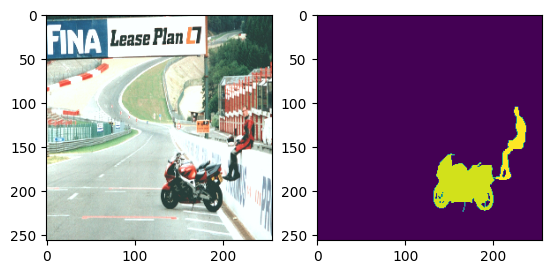

In [6]:
train_dataset = PascalVOCSearchDataset(image_set="train", download=True, transform=train_transform)
test_dataset = PascalVOCSearchDataset(image_set="val", download=True, transform=test_trainsform)
id = random.randint(0, train_dataset.__len__())

image, mask = train_dataset.__getitem__(id)
plt.subplot(1, 2, 1)
plt.imshow(unorm(image).permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.show()


In [7]:
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [8]:
def intersectionAndUnionGPU(output, target, K, ignore_index=255):
    # 'K' classes, output and target sizes are N or N * L or N * H * W, each value in range 0 to K - 1.
    assert (output.dim() in [1, 2, 3])
    assert output.shape == target.shape
    output = output.view(-1)
    target = target.view(-1)
    output[target == ignore_index] = ignore_index
    intersection = output[output == target]
    area_intersection = torch.histc(intersection, bins=K, min=0, max=K-1)
    area_output = torch.histc(output, bins=K, min=0, max=K-1)
    area_target = torch.histc(target, bins=K, min=0, max=K-1)
    area_union = area_output + area_target - area_intersection
    return area_intersection, area_union, area_target

In [9]:
!pip install transformers

In [10]:
from transformers import SegformerForSemanticSegmentation
#device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#load data
batch_size = 16
n_workers = os.cpu_count()
print("num_workers =", n_workers)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=n_workers)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=n_workers)

#model settings
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b4-finetuned-ade-512-512").to(device)

#loss
criterion = nn.CrossEntropyLoss()

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
n_eps = 30

#meter
train_loss_meter = AverageMeter()
intersection_meter = AverageMeter()
union_meter = AverageMeter()
target_meter = AverageMeter()

num_workers = 2


In [11]:
for ep in range(1, 1+n_eps):
    train_loss_meter.reset()
    intersection_meter.reset()
    union_meter.reset()
    target_meter.reset()
    model.train()

    for batch_id, (x, y) in enumerate(tqdm(trainloader), start=1):
        optimizer.zero_grad()
        n = x.shape[0]
        x = x.to(device).float()
        y = y.to(device)
        y_hat = model(x).logits #(B, C, H, W)
        y_hat = F.interpolate(y_hat, y.shape[1:], mode="bilinear")
        loss = criterion(y_hat, y) #(B, C, H, W) >< (B, H, W)
        loss.backward()
        optimizer.step()

        #save metrics
        with torch.no_grad():
            train_loss_meter.update(loss.item())
            y_hat_mask = y_hat.argmax(dim=1).squeeze(1) # (B, C, H, W) -> (B, 1, H, W) -> (B, H, W)
            intersection, union, target = intersectionAndUnionGPU(y_hat_mask.float(), y.float(), 21)
            intersection_meter.update(intersection)
            union_meter.update(union)
            target_meter.update(target)

    #compute iou, dice
    with torch.no_grad():
        iou_class = intersection_meter.sum / (union_meter.sum + 1e-10) #vector 21D
        dice_class = (2 * intersection_meter.sum) / (intersection_meter.sum + union_meter.sum + 1e-10) #vector 21D

        mIoU = torch.mean(iou_class) #mean vector 21D
        mDice = torch.mean(dice_class) #mean vector 21D

    print("EP {}, current_lr = {} , train loss = {} IoU = {}, dice = {}".format(ep, scheduler.get_last_lr(), train_loss_meter.avg, mIoU, mDice))
    scheduler.step()

    if ep >= 25:
        torch.save(model.state_dict(), "modelSegFormer_ep_{}.pth".format(ep))

100%|██████████| 92/92 [04:43<00:00,  3.08s/it]


EP 1, current_lr = [0.0001] , train loss = 1.97405973335971 IoU = 0.06534042954444885, dice = 0.09698884189128876


100%|██████████| 92/92 [04:40<00:00,  3.05s/it]


EP 2, current_lr = [0.0001] , train loss = 0.766130855873875 IoU = 0.18917715549468994, dice = 0.28162601590156555


100%|██████████| 92/92 [04:26<00:00,  2.90s/it]


EP 3, current_lr = [0.0001] , train loss = 0.48675623082596325 IoU = 0.38695380091667175, dice = 0.5321528315544128


100%|██████████| 92/92 [04:22<00:00,  2.86s/it]


EP 4, current_lr = [0.0001] , train loss = 0.33654684443836624 IoU = 0.5512358546257019, dice = 0.6915032863616943


100%|██████████| 92/92 [04:23<00:00,  2.87s/it]


EP 5, current_lr = [0.0001] , train loss = 0.2718870105302852 IoU = 0.6184258460998535, dice = 0.7496570944786072


100%|██████████| 92/92 [04:22<00:00,  2.86s/it]


EP 6, current_lr = [0.0001] , train loss = 0.2173764061020768 IoU = 0.687675952911377, dice = 0.8041152954101562


100%|██████████| 92/92 [04:25<00:00,  2.88s/it]


EP 7, current_lr = [0.0001] , train loss = 0.1849927429271781 IoU = 0.7281205654144287, dice = 0.8330196142196655


100%|██████████| 92/92 [04:24<00:00,  2.88s/it]


EP 8, current_lr = [0.0001] , train loss = 0.16957271074795205 IoU = 0.7473278641700745, dice = 0.848071813583374


100%|██████████| 92/92 [04:24<00:00,  2.87s/it]


EP 9, current_lr = [0.0001] , train loss = 0.15237113865821258 IoU = 0.7668532729148865, dice = 0.8608257174491882


100%|██████████| 92/92 [04:24<00:00,  2.88s/it]


EP 10, current_lr = [0.0001] , train loss = 0.1390459664651881 IoU = 0.7843092083930969, dice = 0.8726317882537842


100%|██████████| 92/92 [04:21<00:00,  2.85s/it]


EP 11, current_lr = [0.0001] , train loss = 0.1352749395629634 IoU = 0.7859300971031189, dice = 0.8740845918655396


100%|██████████| 92/92 [04:19<00:00,  2.83s/it]


EP 12, current_lr = [0.0001] , train loss = 0.12335804663598537 IoU = 0.8053035140037537, dice = 0.8868293762207031


100%|██████████| 92/92 [04:22<00:00,  2.85s/it]


EP 13, current_lr = [0.0001] , train loss = 0.11512051903359267 IoU = 0.8139984011650085, dice = 0.8926547765731812


100%|██████████| 92/92 [04:25<00:00,  2.88s/it]


EP 14, current_lr = [0.0001] , train loss = 0.11029077908429115 IoU = 0.8202903270721436, dice = 0.8969916701316833


100%|██████████| 92/92 [04:19<00:00,  2.82s/it]


EP 15, current_lr = [0.0001] , train loss = 0.11325979232788086 IoU = 0.8163123726844788, dice = 0.8946738839149475


100%|██████████| 92/92 [04:21<00:00,  2.85s/it]


EP 16, current_lr = [0.0001] , train loss = 0.11303113538609899 IoU = 0.8164079189300537, dice = 0.8941386342048645


100%|██████████| 92/92 [04:23<00:00,  2.86s/it]


EP 17, current_lr = [0.0001] , train loss = 0.10448043825833694 IoU = 0.8302910327911377, dice = 0.9034116864204407


100%|██████████| 92/92 [04:21<00:00,  2.84s/it]


EP 18, current_lr = [0.0001] , train loss = 0.09971247961663682 IoU = 0.8351255059242249, dice = 0.9065962433815002


100%|██████████| 92/92 [04:19<00:00,  2.82s/it]


EP 19, current_lr = [0.0001] , train loss = 0.09541567111306865 IoU = 0.8417068123817444, dice = 0.9104589223861694


100%|██████████| 92/92 [04:20<00:00,  2.83s/it]


EP 20, current_lr = [0.0001] , train loss = 0.09168625934778349 IoU = 0.8468170166015625, dice = 0.9136662483215332


100%|██████████| 92/92 [04:22<00:00,  2.85s/it]


EP 21, current_lr = [5e-05] , train loss = 0.08873694219990917 IoU = 0.8487401008605957, dice = 0.9148592352867126


100%|██████████| 92/92 [04:26<00:00,  2.89s/it]


EP 22, current_lr = [5e-05] , train loss = 0.08634296642697376 IoU = 0.852547824382782, dice = 0.9173097610473633


100%|██████████| 92/92 [04:21<00:00,  2.84s/it]


EP 23, current_lr = [5e-05] , train loss = 0.08492800257290187 IoU = 0.855034351348877, dice = 0.9187604784965515


100%|██████████| 92/92 [04:22<00:00,  2.85s/it]


EP 24, current_lr = [5e-05] , train loss = 0.08605206174694974 IoU = 0.8533136248588562, dice = 0.9176368713378906


100%|██████████| 92/92 [04:21<00:00,  2.84s/it]


EP 25, current_lr = [5e-05] , train loss = 0.08336872214694387 IoU = 0.856784462928772, dice = 0.9196378588676453


100%|██████████| 92/92 [04:18<00:00,  2.81s/it]


EP 26, current_lr = [5e-05] , train loss = 0.08356730704722197 IoU = 0.8563375473022461, dice = 0.9192259907722473


100%|██████████| 92/92 [04:21<00:00,  2.84s/it]


EP 27, current_lr = [5e-05] , train loss = 0.0800652802395432 IoU = 0.8624958992004395, dice = 0.9231547713279724


100%|██████████| 92/92 [04:24<00:00,  2.87s/it]


EP 28, current_lr = [5e-05] , train loss = 0.0803526964686487 IoU = 0.8613258004188538, dice = 0.9223889112472534


100%|██████████| 92/92 [04:29<00:00,  2.93s/it]


EP 29, current_lr = [5e-05] , train loss = 0.07818697064953006 IoU = 0.8633493781089783, dice = 0.9236123561859131


100%|██████████| 92/92 [04:23<00:00,  2.87s/it]


EP 30, current_lr = [5e-05] , train loss = 0.07770215266424677 IoU = 0.8650626540184021, dice = 0.9247958660125732


In [13]:
# evaluation
model.eval()
test_intersection_meter = AverageMeter()
test_union_meter = AverageMeter()
test_target_meter = AverageMeter()
with torch.no_grad():
  for batch_id, (x, y) in enumerate(tqdm(testloader), start = 1):
    n = x.shape[0]
    x = x.to(device).float()
    y = y.to(device).long()
    y_hat = model(x).logits
    y_hat = F.interpolate(y_hat, y.shape[1:], mode="bilinear")

    y_hat_mask = y_hat.argmax(dim = 1).squeeze()

    intersection, union, target = intersectionAndUnionGPU(y_hat_mask.float(), y.float(), 21)
    intersection_meter.update(intersection)
    union_meter.update(union)
    target_meter.update(target)

  iou_class = intersection_meter.sum / (union_meter.sum + 1e-10)  # vector 21D
  dice_class = (2 * intersection_meter.sum) / (intersection_meter.sum + union_meter.sum + 1e-10) #vector 21D

  mIoU = torch.mean(iou_class)  #mean vector 21D
  mDice = torch.mean(dice_class)  #mean vector 21D
print("TEST: iou = {}, dice = {}".format( mIoU, mDice))



100%|██████████| 91/91 [04:17<00:00,  2.83s/it]

TEST: iou = 0.7564916014671326, dice = 0.8561788201332092


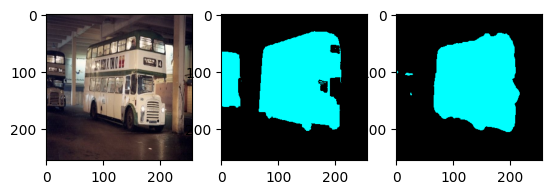

In [19]:
import random
# predict
id = random.randint(0, train_dataset.__len__())

with torch.no_grad():
  model.eval()
  x, y = test_dataset.__getitem__(id)
  y_predict = model(x.unsqueeze(0).to(device)).logits
  y_predict = F.interpolate(y_predict, y.shape, mode="bilinear")
  y_predict = y_predict.argmax(dim=1).squeeze()
  # print(np.unique(y_predict))
  # print(y_predict.shape)
  y_predict = y_predict.cpu().numpy()
  color_mask_predict = np.zeros((*y_predict.shape, 3))
  for i, color in enumerate(VOC_COLORMAP):
    color_mask_predict[y_predict==i] = np.array(color)
  color_mask = np.zeros((*y_predict.shape, 3))
  for i, color in enumerate(VOC_COLORMAP):
    color_mask[y==i] = np.array(color)
  plt.subplot(1,3,1)
  plt.imshow(unorm(x).permute(1, 2, 0))
  plt.subplot(1,3,2)
  plt.imshow(color_mask)
  plt.subplot(1,3,3)
  plt.imshow(color_mask_predict)
  plt.show()